## Extract citation rate by age of publication from dblp data.

First, some setup. We need to pass the right java home here because the spark version we have does not work with newer JDK versions (Java 8 works, though). 


In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib64/jvm/jre-1.8.0-openjdk"
os.environ["SPARK_HOME"] = "/home/sven/spark/spark-2.3.2-bin-hadoop2.7"
os.environ["PYTHONHASHSEED"] = "2"

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

Citation data came from [Arnet Miner](https://aminer.org/citation) in JSON format; we used the dataset V10, but the other versions should also work. The files are large-ish, so we recommend reading and processing them locally rather than to using a colab notebook and uploading them. Change the line below depending on where you read the data from.

In [3]:
citationData = spark.read.json('./dblp-ref-*.json')

Now we'll take (publicationId, list of referenceIds, publication year) for all publications that have at least one reference. Then run a map-reduce combination to map this to
(referenceId + "." + year) -> counter.
Then run another map to split the reference ids and the years apart.

In [4]:
dd = citationData.select("id", "references", "year").filter("references is not NULL").rdd

In [5]:
docsplit = dd.flatMap(lambda row: [('{}.{}'.format(ref, row[2]), 1) for ref in row[1]])

In [6]:
reducestep = docsplit.reduceByKey(lambda c, d : c + d)

In [7]:
idYearCount = reducestep.map(lambda row: (row[0][:-5], int(row[0][-4:]), row[1]))

In [8]:
# make pair rdds so we can join the publication date and the citation dates.
idYear = idYearCount.map(lambda row: (row[0], row[1]))
ddpairs = dd.map(lambda row: (row[0], row[2]))

In [9]:
idYearAge = idYear.join(ddpairs).filter(lambda row: (row[1][0] - row[1][1] >= -2)).map(lambda row: ('{}.{}'.format(row[0], row[1][0]), (row[1][0] - row[1][1])))

Let's do a double check: there are some papers with citations 80+ years post-publication, look them up to make sure this isn't a bug or a fault in the data. Looks to be fine though -- these are all papers that really were published
in the 1930s (looks like they're the oldest papers that DBLP has records for?)
It may be useful to exclude very old papers from stats, since citation behaviour may have changed over time. But for now let's leave them in.

In [10]:
for row in idYearAge.sortBy(lambda x : x[1], ascending=False).take(10):
  d = citationData.filter("id == \'{}\'".format(row[0][:-5])).drop('abstract').collect()
  print("{}".format(d[0]))
    


Row(authors=['Emil L. Post'], id='e254cbb5-e369-49dc-97a2-4d60eaea27dd', n_citation=367, references=[], title='Finite Combinatory Processes--Formulation 1', venue='Journal of Symbolic Logic', year=1936)
Row(authors=['Alonzo Church'], id='c45bdb20-3d36-4d7d-8a83-203e3d3bff9e', n_citation=949, references=[], title='A Note on the Entscheidungsproblem', venue='Journal of Symbolic Logic', year=1936)
Row(authors=['Emil L. Post'], id='e254cbb5-e369-49dc-97a2-4d60eaea27dd', n_citation=367, references=[], title='Finite Combinatory Processes--Formulation 1', venue='Journal of Symbolic Logic', year=1936)
Row(authors=['Alonzo Church'], id='c45bdb20-3d36-4d7d-8a83-203e3d3bff9e', n_citation=949, references=[], title='A Note on the Entscheidungsproblem', venue='Journal of Symbolic Logic', year=1936)
Row(authors=['Frederic B. Fitch'], id='62c68236-b9e5-44dd-b299-e0d03c3e7bf4', n_citation=24, references=[], title='A System of Formal Logic without an Analogue to the Curry W. Operator', venue='Journal of

In [11]:
# join with reducestep to get ref.yearCited -> (age, citationCount)
# take the yearCited out of ref again and reduce.
# That should give us
# refId -> [(age, citationCountAtAge)]
citationCountByAgeAndId = idYearAge.join(reducestep).map(lambda row: (row[0][:-5], [(row[1][0], row[1][1])])).reduceByKey(lambda c, d: c + d)

In [12]:
# not necessary to run this, but gives a quick overview what the data looks like
citationCountByAgeAndId.take(5)

[('ab7d45e0-a7e7-435b-97c7-06715c9d22e2',
  [(3, 1),
   (16, 2),
   (4, 1),
   (12, 1),
   (13, 1),
   (10, 2),
   (21, 1),
   (1, 1),
   (9, 1),
   (6, 3),
   (2, 4),
   (11, 2),
   (15, 1)]),
 ('47bd9dd1-c2e5-4093-bc4b-dac9f44ef27e',
  [(3, 6), (0, 4), (8, 3), (6, 5), (4, 2), (9, 5), (2, 8), (1, 3), (5, 2)]),
 ('e43d13f1-3333-48b6-8cf2-c269d364951c', [(1, 2), (2, 1), (3, 1), (4, 1)]),
 ('7bee614d-3e5a-4416-bf57-0c110bed367a',
  [(17, 6),
   (15, 6),
   (6, 4),
   (8, 2),
   (11, 4),
   (22, 2),
   (9, 3),
   (16, 10),
   (10, 5),
   (12, 8),
   (1, 2),
   (19, 12),
   (4, 3),
   (2, 1),
   (20, 8),
   (13, 7),
   (5, 2),
   (18, 9),
   (14, 4),
   (3, 2),
   (7, 1),
   (21, 9)]),
 ('bec8a70d-2936-48ab-8f13-d37c81457344',
  [(3, 4),
   (18, 1),
   (2, 1),
   (12, 1),
   (4, 3),
   (9, 3),
   (7, 3),
   (1, 1),
   (13, 1),
   (5, 2)])]

In [13]:
# Transform this data so it's just arrays of citation counts where array[i] = citation count at age i.
# Use mapValues and make sure to insert zeroes for missing citation counts.
# This is for plotting the citation counts over time of selected publications. We do this instead of using list(zip(*pairs))
# because we want 0 values to be inserted for missing years. We're not padding the array with 0 citation counts though,
# so if the publication has no citations after age x (either because it was forgotten or because it was published
# less than x years ago), it will not contribute to stats for age x+.

def pairsToArray(pairs):
    d = dict(pairs)
    return [d[x] if (x in d) else 0 for x in range(max(d.keys()) + 1)]

sample = citationCountByAgeAndId.mapValues(pairsToArray).take(5)

In [14]:
#again, not necessary to run this, just gives a glimpse at the data
sample

[('ab7d45e0-a7e7-435b-97c7-06715c9d22e2',
  [0, 1, 4, 1, 1, 0, 3, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1]),
 ('47bd9dd1-c2e5-4093-bc4b-dac9f44ef27e', [4, 3, 8, 6, 2, 2, 5, 0, 3, 5]),
 ('e43d13f1-3333-48b6-8cf2-c269d364951c', [0, 2, 1, 1, 1]),
 ('7bee614d-3e5a-4416-bf57-0c110bed367a',
  [0, 2, 1, 2, 3, 2, 4, 1, 2, 3, 5, 4, 8, 7, 4, 6, 10, 6, 9, 12, 8, 9, 2]),
 ('bec8a70d-2936-48ab-8f13-d37c81457344',
  [0, 1, 1, 4, 3, 2, 0, 3, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1])]

In [15]:
# Next, avg and max citation counts by year over all publications. Below is a dataframe version.
from pyspark.sql.types import StructType, StructField, IntegerType

schema = StructType([StructField('Age', IntegerType(), False),
                     StructField('CitCount', IntegerType(), True)])

# This will fail to count 0 values
# cc = citationCountByAgeAndId.flatMap(lambda row : [(x[0], x[1]) for x in row[1]]).toDF(schema)

# Instead, use pairsToArray to get lists of citation counts (list[i] == citation count at age i)
citCountArrays = citationCountByAgeAndId.mapValues(pairsToArray)
# transform these back to pairs, dropping the publication id. now we have lots of pairs
# (age, citationCount). Could have used aggregateByKey or aggregate here instead and avoided
# the transformation to a dataframe.
ccList = citCountArrays.flatMap(lambda row: [(idx, v) for idx, v in enumerate(row[1])])
cc = ccList.toDF(schema)

from pyspark.sql import functions

averages = cc.groupBy('Age').agg(functions.avg('CitCount').alias('Avg')).orderBy('Age').collect()
maxcount = cc.groupBy('Age').agg(functions.max('CitCount').alias('Max')).orderBy('Age').collect()

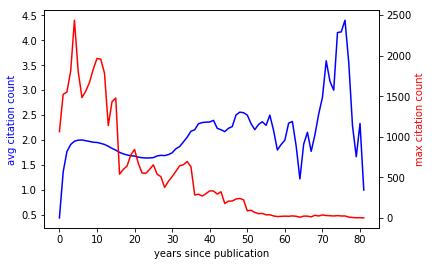

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

years = []
citcounts = []
maxcounts = []
for av in averages:
    years.append(av.Age)
    citcounts.append(av.Avg)

for mx in maxcount:
    maxcounts.append(mx.Max)
    
avgFig = plt.figure()
ax1 = plt.axes()

ax1.set_xlabel('years since publication')
ax1.set_ylabel('avg citation count', color='b')
ax1.plot(years, citcounts, 'b')

ax2 = ax1.twinx()
ax2.set_ylabel('max citation count', color='r')
ax2.plot(years, maxcounts, 'r')

In [17]:
# Try the same aggregation on the rdd, it should be faster.
# citCountArrays is publication id -> [list of citation counts] where the ith entry in the list is the
# number of times the publication was cited when it was i years 'old' (i.e., i years after it was published).
citCountArrays = citationCountByAgeAndId.mapValues(pairsToArray)

# the max len of these is 81. Could extract that number here just to be safe, but we'll just use 100
# as the max age for now. Use rdd.aggregate where the tuples are pairs of arrays. Each array has 100
# entries, one for each year of publication age. The first array accumulates the sums of citation counts,
# the second counts how many times we've seen a citation count for a given year.
startingTuple = ([0] * 100, [0] * 100)

def seqOp(acc, newItem):
    for idx, value in enumerate(newItem[1]):
        acc[0][idx] += value
        acc[1][idx] += 1
    return acc

def combOp(acc1, acc2):
    # acc1 will contain two tuples each with a length of 100. So should acc2.
    return ([x1 + x2 for x1,x2 in zip(acc1[0], acc2[0])], [y1 + y2 for y1,y2 in zip(acc1[1], acc2[1])])

sumsAndCounts = citCountArrays.aggregate(startingTuple, seqOp, combOp)
averageByAggregate = [(x / y if y > 0 else 0) for x,y in zip(sumsAndCounts[0], sumsAndCounts[1])]

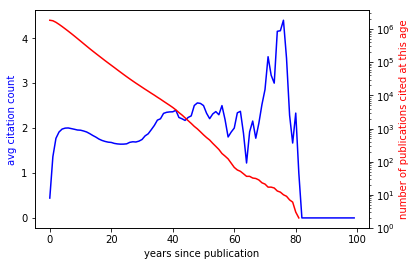

In [18]:
avgFig = plt.figure()
ax1 = plt.axes()

years = range(100)
ax1.set_xlabel('years since publication')
ax1.set_ylabel('avg citation count', color='b')
ax1.plot(years, averageByAggregate, 'b')

# Note the red plot is different data from the graph above where I used dataframes.
# The red line here is a log-scale graph of the number of publications that I had
# citation data for for a given age. It might go some way towards explaining how much
# smoother the blue line is for 'younger' citation ages.
ax2 = ax1.twinx()
ax2.set_ylabel('number of publications cited at this age', color='r')
ax2.semilogy(years, sumsAndCounts[1], 'r')

Average citation counts get high and spiky at about 70 years post-publication, perhaps because DBLP does not track many older papers, and those that they do track tend to be classics (papers by Post, Church, Turing, Kleene). These papers were published in the 1930's, so the rise in citation rates started in the early 2000's which makes sense given overall increases in publication rates.

Papers sorted into quantiles by their overall citation count. For simplicity, we'll use the n_citation field even though it does not line up perfectly with references that are actually in DBLP.
Quantiles of n_citation values:

In [19]:
n_citation_quantiles = citationData.approxQuantile("n_citation", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.0)

In [20]:
n_citation_quantiles

[0.0, 0.0, 2.0, 4.0, 11.0, 33.0, 50.0, 50.0, 50.0]

In [21]:
# Can this be correct? Count below shows we have so many pubs at 0 citations that they get two buckets. Maybe same
# situation at 50 (is that a DBLP artifact? looks suspiciously round). The numbers are plausible -- about 300k
# publications per decile adds up to the ca. 3 million publications in the dataset. This does mean we should adapt
# the effective quantile boundary list though.
pubsWithNoCitations = citationData.filter("n_citation = 0").count()
pubsWithFewCitations = citationData.filter("n_citation < 3").filter("n_citation > 0").count()
pubsWith50Citations = citationData.filter("n_citation = 50").count()
pubsWithManyCitation = citationData.filter("n_citation > 50").count()

print("no citations: {}, fewer than 3: {}, exactly 50: {}, more than 50: {}".format(\
    pubsWithNoCitations, pubsWithFewCitations, pubsWith50Citations, pubsWithManyCitation))

no citations: 718250, fewer than 3: 333232, exactly 50: 852684, more than 50: 306507


In [22]:
# Now sort paper ids into buckets. Use an adapted quantile boundary list. Note these are not quantiles --
# the first bucket (0 citations) contains about 700k publications, the 50-51 bucket about 850k, so they're
# each roughly the size of two to three deciles.
buckets = [0.0, 2.0, 4.0, 11.0, 33.0, 50.0, 51.0]
def bucketForCitCount(citCount):
    for idx, qq in enumerate(buckets):
        if citCount < qq:
            return idx
    return len(n_citation_quantiles)

pubIdWithBucket = citationData.select("id", "n_citation").rdd.mapValues(lambda x : bucketForCitCount(x))

In [23]:
pubIdWithBucket.take(5)

[('00127ee2-cb05-48ce-bc49-9de556b93346', 1),
 ('001c58d3-26ad-46b3-ab3a-c1e557d16821', 6),
 ('001c8744-73c4-4b04-9364-22d31a10dbf1', 6),
 ('00338203-9eb3-40c5-9f31-cbac73a519ec', 1),
 ('0040b022-1472-4f70-a753-74832df65266', 2)]

In [24]:
citCountByAgeWithBucket = citCountArrays.join(pubIdWithBucket).coalesce(100)

In [25]:
citCountByAgeWithBucket.take(5)

[('47bd9dd1-c2e5-4093-bc4b-dac9f44ef27e', ([4, 3, 8, 6, 2, 2, 5, 0, 3, 5], 9)),
 ('7bee614d-3e5a-4416-bf57-0c110bed367a',
  ([0, 2, 1, 2, 3, 2, 4, 1, 2, 3, 5, 4, 8, 7, 4, 6, 10, 6, 9, 12, 8, 9, 2],
   9)),
 ('e519137e-4ed3-413a-97a8-05570b589701',
  ([6, 8, 14, 18, 24, 24, 17, 22, 3], 9)),
 ('abaae3da-e367-457d-b0cf-7ae54883669a', ([0, 0, 1, 2], 3)),
 ('972a8d04-7640-43f8-89d4-5f51d5788378',
  ([0, 7, 10, 8, 11, 17, 22, 18, 20, 17, 18, 20, 9, 13, 7], 9))]

In [26]:
# Now we want to group by the bucket, so map and make the buckets the keys, dropping the pub ids.
# Then use aggregateByKey with the aggregation settings declared above for the overall averages.
citCountByAgeWithBucket.map(lambda row: (row[1][1], row[1][0])).take(5)

[(9, [4, 3, 8, 6, 2, 2, 5, 0, 3, 5]),
 (9, [0, 2, 1, 2, 3, 2, 4, 1, 2, 3, 5, 4, 8, 7, 4, 6, 10, 6, 9, 12, 8, 9, 2]),
 (9, [6, 8, 14, 18, 24, 24, 17, 22, 3]),
 (3, [0, 0, 1, 2]),
 (9, [0, 7, 10, 8, 11, 17, 22, 18, 20, 17, 18, 20, 9, 13, 7])]

In [27]:
startingTuple = ([0] * 100, [0] * 100)

def seqOp(acc, newItem):
    for idx, value in enumerate(newItem):
        acc[0][idx] += value
        acc[1][idx] += 1
    return acc

def combOp(acc1, acc2):
    # acc1 will contain two tuples each with a length of 100. So should acc2.
    return ([x1 + x2 for x1,x2 in zip(acc1[0], acc2[0])], [y1 + y2 for y1,y2 in zip(acc1[1], acc2[1])])

sumsAndCounts = citCountByAgeWithBucket.map(lambda row: (row[1][1], row[1][0])).aggregateByKey(startingTuple, seqOp, combOp)
# sumsAndCounts contains tuples of the form (<bucket>, ([list of sums of citation counts], [list of citation counts]))
averageByAggregate = sumsAndCounts.mapValues(lambda row: ([(x / y if y > 0 else 0) for x,y in zip(row[0], row[1])]))

averagesByBucket = averageByAggregate.collect()

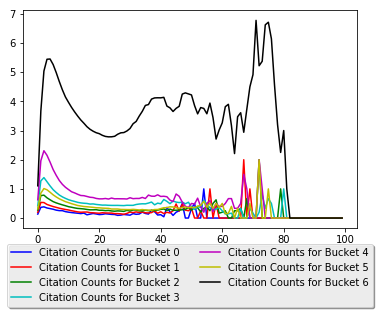

In [28]:
fig = plt.figure()
ax = plt.axes()

colours = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w', 'rosybrown']

for idx, s in enumerate(averagesByBucket):
    x = range(len(s[1]))
    ax.plot(x, s[1], color=colours[idx], label="Citation Counts for Bucket {}".format(idx))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

The citation count development really isn't significantly different per bucket except for (maybe) the bucket with the most citations (over 50 overall).

In [29]:
from pyspark.sql.functions import array_contains, lower, col

# Proceedings of VLDB conference changed their name at some point
vldbPapers1 = citationData.filter("lower(venue) like '%very large data bases%'")
vldbPapers2 = citationData.filter("lower(venue) like '%vldb endowment%'")
vldbPapers = vldbPapers1.union(vldbPapers2).select("authors", "id", "title", "venue", "year").collect()

In [30]:
vldbids = vldbPapers1.union(vldbPapers2).select("id").collect()
vldbarray = [str(row.id) for row in vldbids]

In [31]:
# Look at winners of the VLDB 10-year best paper award.
# Obtained here: http://www.vldb.org/archives/10year.html
vldb10YearBest = [
    # Nilesh N. Dalvi, Dan Suciu: Efficient query evaluation on probabilistic databases (2004)
    'df3ea837-9b41-44e4-a049-0ad9d5b65853',
    # Manku, Motwani: Approximate frequency counts over data streams (2012)
    # Mislaid at wrong publication date
    'ce60ea5e-1cdb-415a-9c56-231db02111c4',
    # Jayant Madhavan,Philip A. Bernstein,Erhard Rahm: Generic Schema Matching with Cupid (2001)
    '91556b20-c53e-4687-82e2-7c3c1e893f0b',
    # Bettina Kemme,Gustavo Alonso: Database replication: a tale of research across communities (2010)
    # Note DBLP has this misclassified under the later pub date
    '51614021-0039-48a3-b62b-13dd593a87be',
    # Boncz, Manegold, Kersten: Database Architecture Optimized for the New Bottleneck: Memory Access. (1999)
    '1c14e793-fc96-465e-949a-b109b6c4a762',
    # also published in IEEE as 'ee631708-8eb7-48ef-9e93-2cc0a3c145c0'
    
    # Weber, Schek, Blott: A Quantitative Analysis and Performance Study for Similarity-Search Methods in High-Dimensional Spaces (1998)
    '7a5b23b4-b171-4c19-8925-167583868f93'
    # Chaudhuri, Narasayva: An Efficient Cost-Driven Index Selection Tool for Microsoft SQL Server (1997)
    '720f4495-31e3-4f14-b748-e30188147bcc',
    # Levy, Rajaraman, Ordille: Querying Heterogeneous Information Sources Using Source Descriptions (1996)
    'd5b735f0-712a-4000-9176-54d487fc7bf9',
    # Konopnicki, Shmueli: W3QS: A Query System for the World-Wide Web (1995)
    '6b95f187-1b14-46d4-965f-50771f2453fb',
  # Bancilhon, Kim and Korth: A Model of CAD Transactions (1985)
  'ec8ed5f7-51f6-47e3-8b04-97e5fe0122b7',
  # Carey, DeWitt, Richardson, Shekita: Object and File Management in the EXODUS extensible database system (1986)
  '38d1e121-9085-4ba7-a410-f4c5092bace7',
   # Sellis, Roussopoulos, Faloutsos: The R+-Tree: A Dynamic Index for Multi-Dimensional Objects (1987)
  '783e5a24-8505-4817-9566-36b1a478a6be',
  # Bitton, Gray: Disk Shadowing (1988)
  'caedea34-0d62-4fde-81e0-bf28bb00172c',
  # Rothermel, Mohan: ARIES/NT: a recovery method based on write-ahead logging for nested transactions (1989)
    '923a01ef-c302-41cc-a30e-49709ef84a89',
  # Ceri, Widom: Deriving Production Rules for Constraint Maintainance (1990)
    '19ac2523-01b1-49d5-94db-f5b824264366',
  # Dayal, Hsu, Ladin: A Transactional Model for Long-Running Activities (1991)
    'fc3727a8-3618-4202-b416-a6cdb01410a9',
  # Monkeberg, Weikum: Performance Evaluation of an Adaptive and Robust Load Control Method for the Avoidance of Data-Contention Thrashing (1992)
    '3fba053a-72ab-485b-bf16-227d196db160',
    # Imielinski, Badrinath: Querying in Highly Mobile Distributed Environments (1992)
    '5a1ded12-77ad-4d92-b5f1-e7d0ce7768c1',
  # Ioannidis: Universality of Serial Histograms (1993)
  'db115e6b-db3c-4088-afc2-8cc84ee40466',
  # Agrawal, Srikant: Fast Algorithms for Mining Association Rules in Large Databases (1994)
    '34b7e270-80d7-46d5-a6f1-e50087a8d045',
]

In [32]:
vldbCitationHistory = citCountArrays.filter(lambda row: row[0] in vldb10YearBest).collect()
vldbCitNoCollect = citCountArrays.filter(lambda row: row[0] in vldb10YearBest)
allvldbCitationHistory = citCountArrays.filter(lambda row: row[0] in vldbarray).collect()
allvldbNoCollect = citCountArrays.filter(lambda row: row[0] in vldbarray)

In [33]:
vldbList = allvldbNoCollect.flatMap(lambda row: [(idx, v) for idx, v in enumerate(row[1])])
vv = vldbList.toDF(schema)

vaverages = vv.groupBy('Age').agg(functions.avg('CitCount').alias('Avg')).orderBy('Age').collect()
vmaxcount = vv.groupBy('Age').agg(functions.max('CitCount').alias('Max')).orderBy('Age').collect()

We now compare the 10-year best paper award VLDB papers to the average citation count of all VLDB papers. 

In [34]:
vaverages

[Row(Age=0, Avg=0.6082731123847496),
 Row(Age=1, Avg=3.2832747363134103),
 Row(Age=2, Avg=4.68223805753497),
 Row(Age=3, Avg=5.129105969722937),
 Row(Age=4, Avg=5.318125),
 Row(Age=5, Avg=5.151855635001702),
 Row(Age=6, Avg=4.870168855534709),
 Row(Age=7, Avg=4.553482587064677),
 Row(Age=8, Avg=4.196270396270396),
 Row(Age=9, Avg=3.9302446642373763),
 Row(Age=10, Avg=3.6951147733961154),
 Row(Age=11, Avg=3.666444296197465),
 Row(Age=12, Avg=3.3752825923134893),
 Row(Age=13, Avg=3.2354430379746835),
 Row(Age=14, Avg=2.901140684410646),
 Row(Age=15, Avg=2.872707659115426),
 Row(Age=16, Avg=2.70933014354067),
 Row(Age=17, Avg=2.537837837837838),
 Row(Age=18, Avg=2.540372670807453),
 Row(Age=19, Avg=2.261986301369863),
 Row(Age=20, Avg=1.9980544747081712),
 Row(Age=21, Avg=1.8820960698689957),
 Row(Age=22, Avg=1.9772151898734178),
 Row(Age=23, Avg=1.237082066869301),
 Row(Age=24, Avg=1.1263537906137184),
 Row(Age=25, Avg=1.0991735537190082),
 Row(Age=26, Avg=1.2376237623762376),
 Row(Age=2

In [35]:
vldbavg = [('vldb average',
[0.6082731123847496,
3.2832747363134103,
4.68223805753497,
5.129105969722937,
5.318125,
5.151855635001702,
4.870168855534709,
4.553482587064677,
4.196270396270396,
3.9302446642373763,
3.6951147733961154,
3.666444296197465,
3.3752825923134893,
3.2354430379746835,
2.901140684410646,
2.872707659115426,
2.70933014354067,
2.537837837837838,
2.540372670807453,
2.261986301369863,
1.9980544747081712,
1.8820960698689957,
1.9772151898734178,
1.237082066869301,
1.1263537906137184,
1.0991735537190082,
1.2376237623762376,
1.2241379310344827,
1.0785714285714285,
1.192,
1.0467289719626167,
0.8636363636363636,
1.196969696969697,
1.2,
1.6,
1.6129032258064515,
1.608695652173913,
1.375,
1.75,
1.5555555555555556,
1.0,
3.0])]


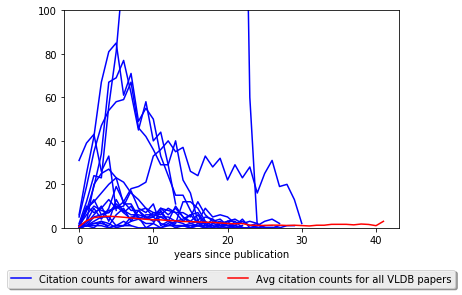

In [36]:
fig = plt.figure()
ax = plt.axes()

colours = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w', 'rosybrown']

ax.set_xlabel('years since publication')

#for idx, s in enumerate(fivevldb):
for idx, s in enumerate(vldbCitationHistory):
    x = range(len(s[1]))
    if (idx != 0):
        ax.plot(x, s[1], color=colours[0])
#    ax.plot(x, s[1], color=colours[0], label="Citation Counts for id {}".format(s[0]))
    ax.set_ylim(bottom=0, top=100)

for idx, s in enumerate(vldbCitationHistory):
    x = range(len(s[1]))
    if (idx == 0):
        ax.plot(x, s[1], color=colours[0], label="Citation counts for award winners")
#    ax.plot(x, s[1], color=colours[0], label="Citation Counts for id {}".format(s[0]))   
    
    
for idx, s in enumerate(vldbavg):    
    x = range(len(s[1]))
    ax.plot(x, s[1], color=colours[1], label="Avg citation counts for all VLDB papers".format(s[0]))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), shadow=True, ncol=2)
    